# nodebook 09b: Optimizer tweaks

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from functools import partial

In [4]:
import torch.nn.functional as F

In [5]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from pathlib import Path

## MNIST

In [6]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh,bs, output_features = 50,512,y_train.max().item()+1
train_ds,valid_ds      = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl     = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                           DataLoader(valid_ds,  batch_size=bs*2) )
data                   = DataBunch( train_dl, valid_dl )

In [8]:
mnist_view = view_tfm(1,28,28)
n_filters_pr_layer = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view) ]


In [9]:
cbfs      = cbfs_base.copy()
cbfs.append(LR_Finder)
model     = get_cnn_model(n_filters_pr_layer, output_features, layer=conv_layer)
init_cnn( model )
opt       = torch.optim.SGD(model.parameters(), lr=0.4)
learn     = Learner( model, data, loss_func, opt=opt, cb_funcs=cbfs)

In [10]:
%time learn.fit(1)

CPU times: user 31.1 s, sys: 276 ms, total: 31.4 s
Wall time: 4.76 s


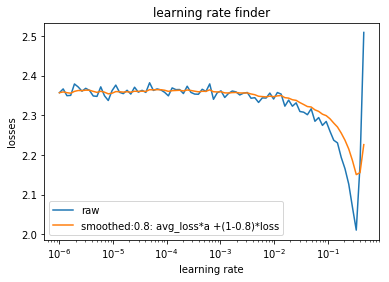

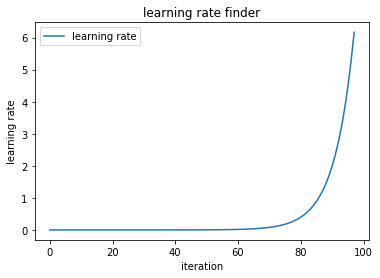

In [11]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,16),plt.show()
learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [12]:
#Training: create model again because current LRFInd does not restore settings in model and opt
cbfs      = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
            #+ [SimpelCudaCallback]
model     = get_cnn_model(n_filters_pr_layer, output_features, layer=conv_layer)

init_cnn( model )
opt       = torch.optim.SGD(model.parameters(), lr=.4)
learn     = Learner( model, data, loss_func, opt=opt, cb_funcs=cbfs)

In [13]:
%time learn.fit(1)

train: [1.66349140625, tensor(0.4435)]
valid: [0.6471603515625, tensor(0.7782)]
CPU times: user 30.2 s, sys: 235 ms, total: 30.4 s
Wall time: 4.5 s


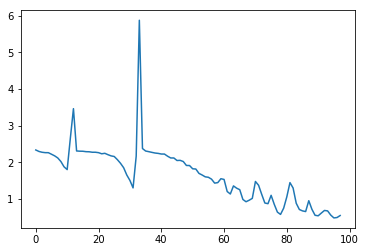

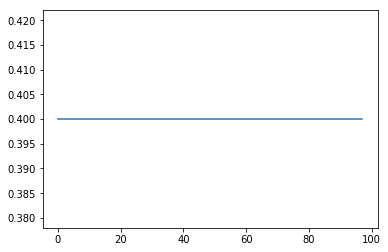

tensor(0.6622)

In [14]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [15]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view) ]

train: [1.9478334375, tensor(0.3331)]
valid: [0.845693359375, tensor(0.6925)]


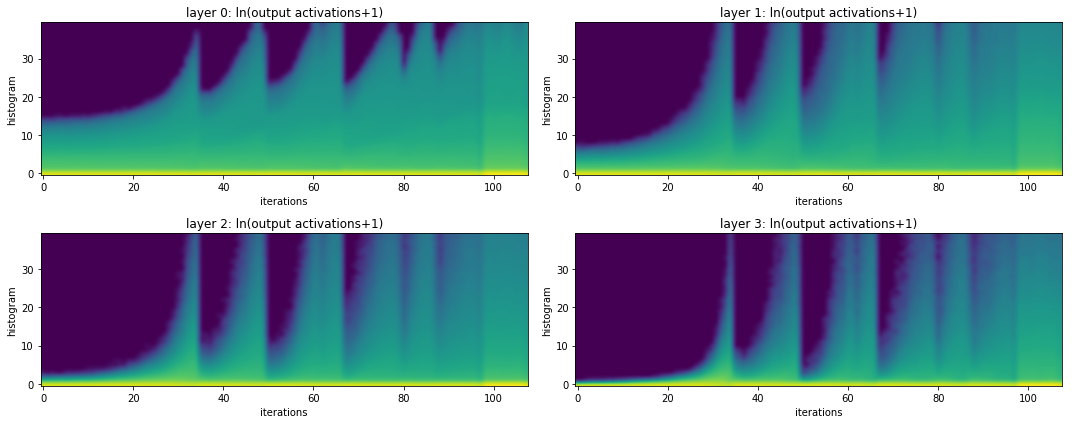

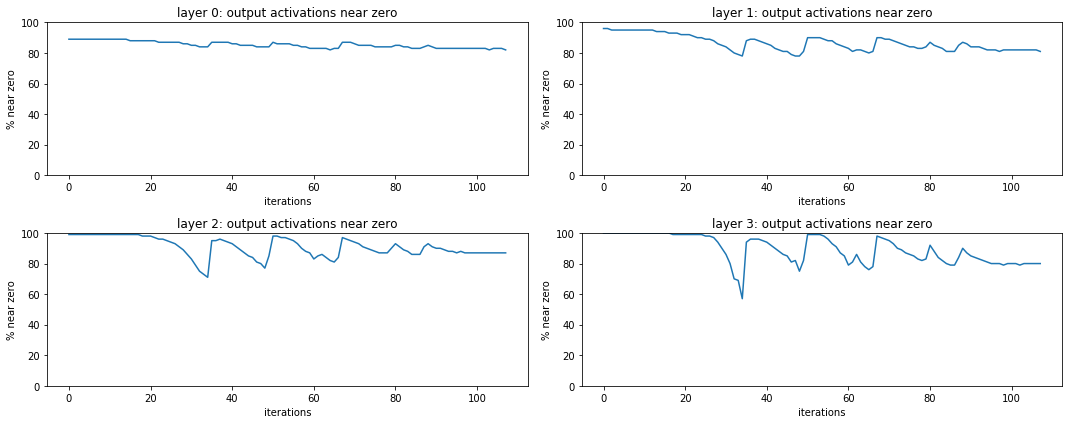

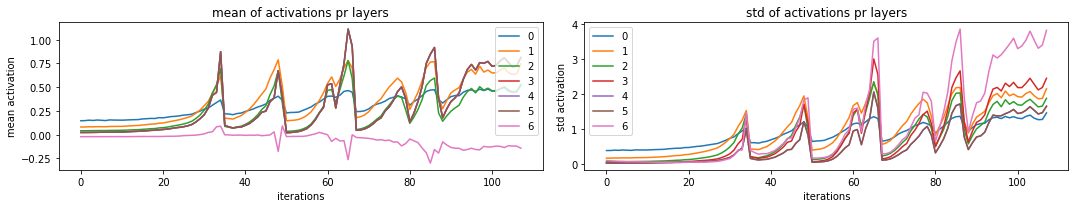

In [16]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(n_filters_pr_layer, output_features, layer=conv_layer)
learn = Learner( model, data, loss_func, opt=torch.optim.SGD(model.parameters(), lr=.4), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )

train: [1.058103203125, tensor(0.6283)]
valid: [0.195312158203125, tensor(0.9386)]
train: [0.18106541015625, tensor(0.9446)]
valid: [0.13887669677734374, tensor(0.9602)]
train: [0.10535673828125, tensor(0.9684)]
valid: [0.10318092041015625, tensor(0.9686)]
train: [0.0784922998046875, tensor(0.9767)]
valid: [0.07827219848632813, tensor(0.9783)]
train: [0.0652192724609375, tensor(0.9802)]
valid: [0.076770703125, tensor(0.9777)]
train: [0.054698525390625, tensor(0.9834)]
valid: [0.06874218139648437, tensor(0.9792)]
train: [0.0461450146484375, tensor(0.9863)]
valid: [0.07508922119140625, tensor(0.9771)]
train: [0.04021843994140625, tensor(0.9876)]
valid: [0.06361690063476562, tensor(0.9812)]


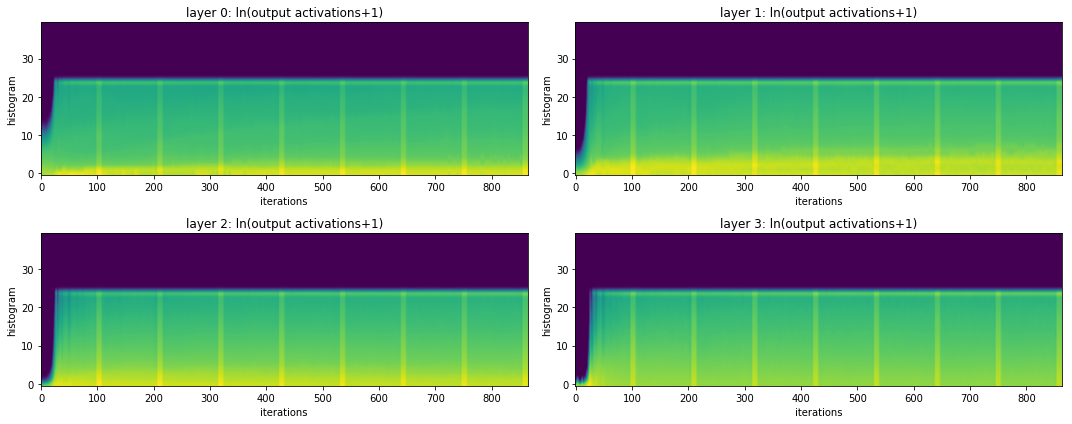

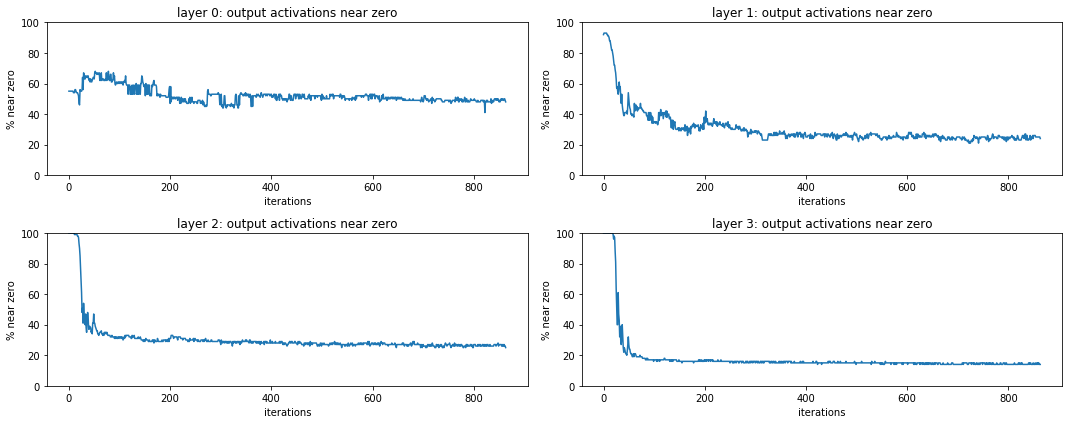

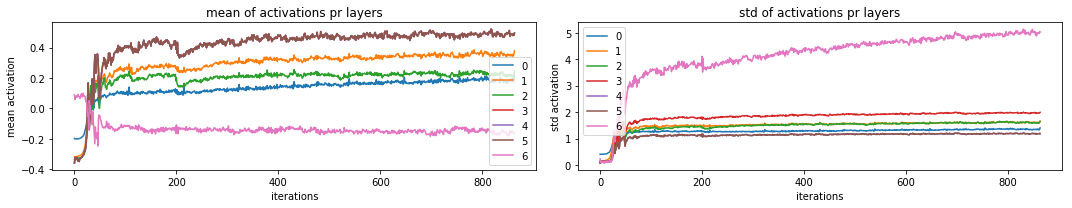

In [17]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(n_filters_pr_layer, output_features, conv_layer, leak=0.1, sub=0.4, maxv=6.)
learn = Learner( model, data, loss_func, opt=torch.optim.SGD(model.parameters(), lr=1.), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(8)
    plot_layer_stats( hooks )

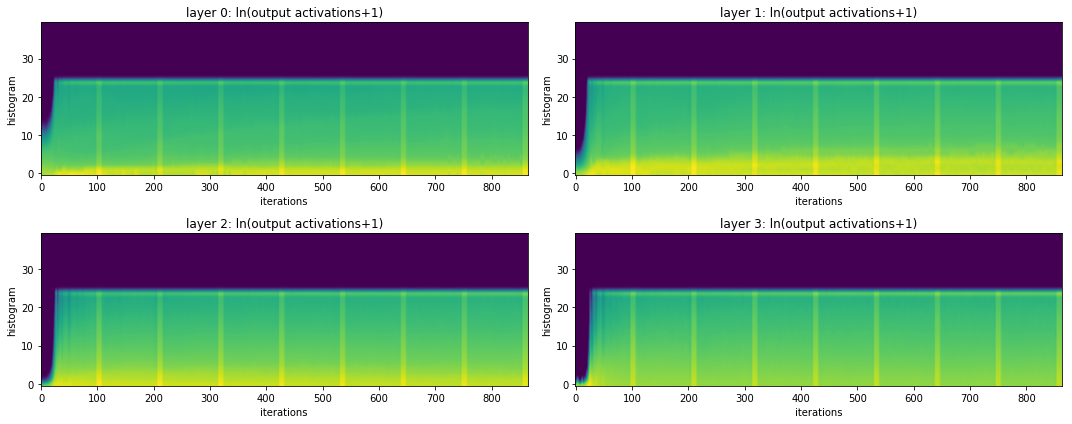

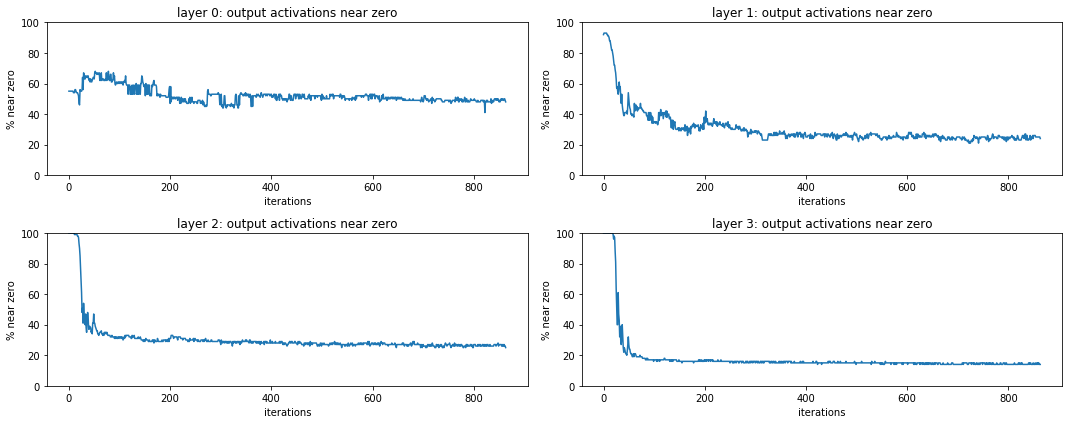

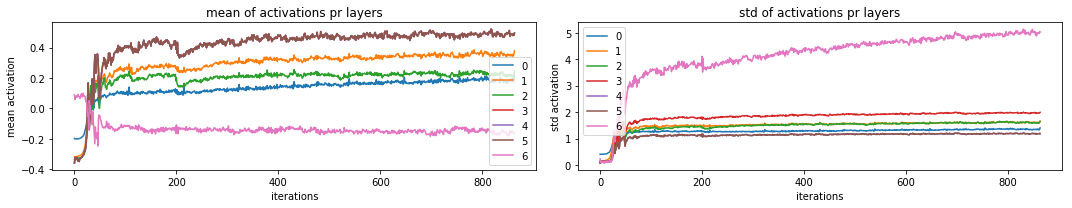

In [18]:
plot_layer_stats( hooks )

## Imagenette data